## Normal Two view reconstruction with LabelMe points

This notebook aims to do two-view reconstruction on the hand labeled points that were extracted from Labelme. The results that are visualized are optimized. 

Do all imports.

In [1]:
# For input/output
from pathlib import Path

# For numerical methods
import numpy as np

# For image processing and visualization of results
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# For optimization with symforce
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf
from symforce.values import Values
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.opt.noise_models import BarronNoiseModel
import sym

Function to print things nicely.

In [2]:
def myprint(M):
    if M.shape:
        with np.printoptions(linewidth=150, formatter={'float': lambda x: f'{x:10.4f}'}):
            print(M)
    else:
        print(f'{M:10.4f}')

Function to compute projection error.

In [3]:
def apply_transform(R_inB_ofA, p_inB_ofA, p_inA):
    p_inB = np.row_stack([
        (R_inB_ofA @ p_inA_i + p_inB_ofA) for p_inA_i in p_inA
    ])
    return p_inB

def project(K, R_inB_ofA, p_inB_ofA, p_inA, warn=True):
    p_inB = apply_transform(R_inB_ofA, p_inB_ofA, p_inA)
    if not np.all(p_inB[:, 2] > 0):
        if warn:
            print('WARNING: non-positive depths')
    q = np.row_stack([K @ p_inB_i / p_inB_i[2] for p_inB_i in p_inB])
    return q[:, 0:2]

def projection_error(K, R_inB_ofA, p_inB_ofA, p_inA, b, warn=True):
    b_pred = project(K, R_inB_ofA, p_inB_ofA, p_inA, warn=True)
    return np.linalg.norm(b_pred - b, axis=1)

Load two images

In [4]:
img1 = cv2.imread("/Users/arnabhardwaj/Downloads/experiment/view_0_b.jpg")#cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img1= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("/Users/arnabhardwaj/Downloads/experiment/view_1_b.jpg")#cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img2= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)



Import the labeled points from LabelMe for both images

In [5]:
import json
with open('/Users/arnabhardwaj/Downloads/experiment/view_0_b.json') as user_file:
    file_contents = user_file.read()
data = json.loads(file_contents)

for obj in data['shapes']:
    label = obj['label']
    points=obj['points']

    
label_points_dict = {}

for obj in data['shapes']:
    label = obj['label']
    points = obj['points']
    label_points_dict[label] = points


b0 = data['shapes'][0]['points']
print(len(b0))
for obj in data['shapes'][1:-1]:
    points = obj['points']
    b0 = np.concatenate((b0, points), axis=0)
    
b0 = np.array(b0)

30


In [6]:
with open('/Users/arnabhardwaj/Downloads/experiment/view_1_b.json') as user_file:
    file_contents = user_file.read()
data = json.loads(file_contents)

for obj in data['shapes']:
    label = obj['label']
    points=obj['points']

    
label_points_dict = {}

for obj in data['shapes']:
    label = obj['label']
    points = obj['points']
    label_points_dict[label] = points


b1 = data['shapes'][0]['points']

for obj in data['shapes'][1:-1]:
    points = obj['points']
    b1 = np.concatenate((b1, points), axis=0)
    
b1 = np.array(b1)


Visualize all matches.

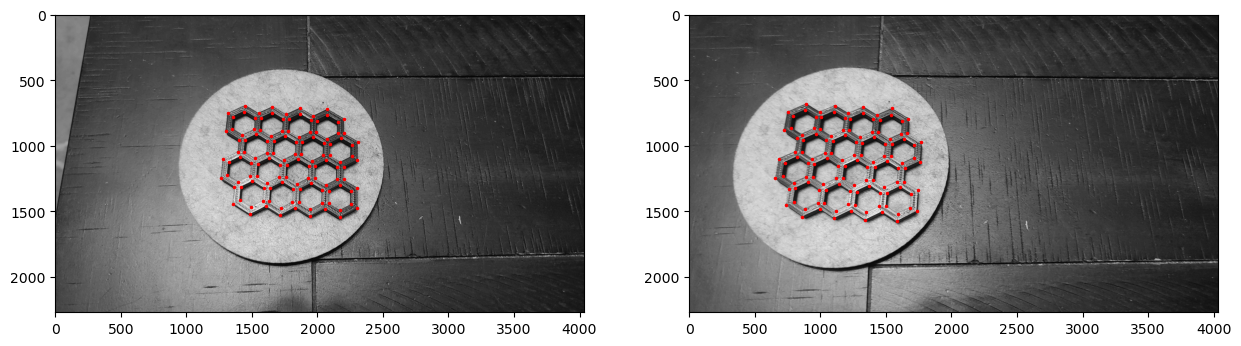

In [7]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Show images
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

ax1.plot(b0[:, 0], b0[:, 1], 'r.', markersize=3)
ax2.plot(b1[:, 0], b1[:, 1], 'r.', markersize=3)

plt.show()

Define camera matrix.

In [ ]:
K=np.array([[ 3210.7132,     0.0000,  2047.7812],
 [    0.0000,  3220.0556,  1214.7876],
 [    0.0000,     0.0000,     1.0000]])

Get image coordinates of matches.

## Two-view reconstruction with OpenCV

The number of inliers is calculated with OpenCV: 

In [ ]:
# Get solution
num_inliers_cv, E_cv, R_inB_ofA_cv, p_inB_ofA_cv, mask_cv = cv2.recoverPose(
    b0.copy(),
    b1.copy(),
    K, np.zeros(4),
    K, np.zeros(4),
)

# Flatten the position (returned as a 2d array by default)
p_inB_ofA_cv = p_inB_ofA_cv.flatten()
mask_cv = mask_cv.flatten()

Estimate $p^A_1, \dotsc, p^A_n$.

In [ ]:
points = cv2.triangulatePoints(
    K @ np.column_stack([np.eye(3), np.zeros(3)]),
    K @ np.column_stack([R_inB_ofA_cv, p_inB_ofA_cv]),
    b0.copy().T,
    b1.copy().T,
)

# Normalize points
points /= points[-1, :]

# Extract non-homogeneous coordinates
p_inA_cv = points[0:3, :].T

How many inliers.

In [ ]:
print(f'OpenCV found {num_inliers_cv} inliers out of {len(mask_cv)}')

Get subsets of points that were declared inliers and outliers by OpenCV.

In [ ]:
a_inliers_cv = np.array([a_i for a_i, mask_i in zip(b0, mask_cv) if mask_i])
b_inliers_cv = np.array([b_i for b_i, mask_i in zip(b1, mask_cv) if mask_i])
assert(len(a_inliers_cv) == np.count_nonzero(mask_cv))
assert(len(b_inliers_cv) == np.count_nonzero(mask_cv))

p_inA_inliers_cv = np.array([p_inA_i for p_inA_i, mask_i in zip(p_inA_cv, mask_cv) if mask_i])
assert(len(p_inA_inliers_cv) == np.count_nonzero(mask_cv))

a_outliers_cv = np.array([a_i for a_i, mask_i in zip(b0, mask_cv) if not mask_i])
b_outliers_cv = np.array([b_i for b_i, mask_i in zip(b1, mask_cv) if not mask_i])
p_inA_outliers_cv = np.array([p_inA_i for p_inA_i, mask_i in zip(p_inA_cv, mask_cv) if not mask_i])

Get reprojection errors.

In [ ]:
# For inliers
e_a_inliers_cv = projection_error(K, np.eye(3), np.zeros(3), p_inA_inliers_cv, a_inliers_cv)
e_b_inliers_cv = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_inliers_cv, b_inliers_cv)

# For outliers
e_a_outliers_cv = projection_error(K, np.eye(3), np.zeros(3), p_inA_outliers_cv, a_outliers_cv)
e_b_outliers_cv = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_outliers_cv, b_outliers_cv)

## Two-view reconstruction with code from scratch

### Initial guess

Our implementation of two-view reconstruction.

In [ ]:
def skew(v):
    assert(type(v) == np.ndarray)
    assert(v.shape == (3,))
    return np.array([[0., -v[2], v[1]],
                     [v[2], 0., -v[0]],
                     [-v[1], v[0], 0.]])


In [ ]:
#This is the process of finding the essential matrix. See theory above. 
def findE(alpha_calc, beta_calc):
    matrix= []
    for i in range (0, len(alpha_calc)):
        matrix.append(np.kron(alpha_calc[i], beta_calc[i]).T)

    matrix= np.array(matrix)



    Udprime, Sdprime, Vtdprime= np.linalg.svd(matrix)


    Edprime= Vtdprime[-1]
    Edprime= Edprime.reshape((3, 3)).T


    E_norm= (np.sqrt(2)/ np.linalg.norm(Edprime))


    Eprime= E_norm*Edprime

    Uprime, Sprime, Vtprime= np.linalg.svd(Eprime)

    Vprime= Vtprime.T


    u1prime= Uprime[:, 0]
    u2prime= Uprime[:, 1]
    u3prime= Uprime[:, 2]


    U= np.hstack((u1prime, u2prime, np.linalg.det(Uprime)*u3prime))

    U= U.reshape(3,3).T


    S= np.diag((1, 1, 0))


    v1prime= Vtprime[:, 0]
    v2prime= Vtprime[:, 1]
    v3prime= Vtprime[:, 2]


    V= np.hstack((v1prime, v2prime, np.linalg.det(Vtprime)*v3prime))

    V=V.reshape((3, 3))

    W= np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    E= U@S@V.T


    u3= U[:, -1]
    
    
    return E, W, V, U, u3




In [ ]:
#This is the process of using Ransac to find the optimal essential matrix. See theory above. 
def get_bestE(a, b):
    alpha_calc = np.array([np.linalg.inv(K) @ np.concatenate([a_i, [1.]]) for a_i in a])
    beta_calc = np.array([np.linalg.inv(K) @ np.concatenate([b_i, [1.]]) for b_i in b])
    num_inliers_best=0
    E_best=None
    W_best= None
    V_best= None
    U_best= None
    u3_best= None

    epsilon=1e-5
    
    
    for i in range (0, 5000):

        nums = np.random.randint(0, alpha_calc.shape[0] , size=8)
        alphas = np.array([alpha_calc[i] for i in nums])
        betas = np.array([beta_calc[i] for i in nums])
        epsilon= 1e-3
        
        E_, W, V, U, u3= findE(alphas, betas)

        num_inliers=0
        for i in range (0, len(alpha_calc)):
            e3=np.array([0, 0, 1])
            e3_skew= skew(e3)
            
            alpha_i = alpha_calc[i]
            beta_i = beta_calc[i]
            dBi = np.abs((beta_i.T @ E_@ alpha_i) / np.linalg.norm(e3_skew @ E_ @ alpha_i))
            dAi = np.abs((alpha_i.T @ E_.T @ beta_i) / np.linalg.norm(e3_skew @ E_.T @ beta_i))
            
            if dBi<epsilon and dAi<epsilon: 
                num_inliers+=1
            
        if num_inliers > num_inliers_best:
            E_best = E_
            W_best= W
            V_best= V
            U_best= U
            u3_best =u3
            
            num_inliers_best = num_inliers

    
    return E_best, W_best, V_best, U_best, u3_best
                


In [ ]:
def skew(v):
    assert(type(v) == np.ndarray)
    assert(v.shape == (3,))
    return np.array([[0., -v[2], v[1]],
                     [v[2], 0., -v[0]],
                     [-v[1], v[0], 0.]])

#The theory for the two view triangulation is taken from the corresponding in class activity
def twoview_triangulate(alpha, beta, R_inB_ofA, p_inB_ofA):
    # INPUTS (alpha, beta, R_inB_ofA, p_inB_ofA)
    #  alpha        normalized coordinates of points in image A
    #  beta         normalized coordinates of points in image B
    #  R_inB_ofA    orientation of frame A in frame B
    #  p_inB_ofA    position of frame A in frame B
    #
    # OUTPUTS (p_inA, p_inB, mask)
    #  p_inA        triangulated points in frame A
    #  p_inB        triangulated points in frame B
    #  mask         1d array of length equal to number of triangulated points,
    #               with a "1" for each point that has positive depth in both
    #               frames and with a "0" otherwise

    
    lambda_a=[]
    lambda_b=[]
    p_inA_arr=[]
    p_inB_arr=[]

    
    mask=[]
    for i in range(0, len(alpha)):
        u= skew(beta[i].flatten())@R_inB_ofA@alpha[i].flatten()
        v= -skew(beta[i].flatten())@p_inB_ofA
    
        lambdaa= u.T@v/ (u.T@u)
                
        lambda_a.append(lambdaa)
        
        lambdab= np.array([0, 0, 1]).T@(lambdaa*R_inB_ofA@alpha[i].flatten()+ p_inB_ofA)
    
        lambda_b.append(lambdab)
        beta_i= np.array(beta[i])
        
        alphai= alpha[i].flatten()
                
        left_matrix= np.hstack((-skew((beta_i))@p_inB_ofA, np.zeros(len(p_inB_ofA)))) #changed
        right_matrix=np.vstack((skew(beta_i)@R_inB_ofA, skew(alphai)))
        
        p_inAi= np.linalg.pinv(right_matrix)@left_matrix
        
        p_inBi= R_inB_ofA@p_inAi+p_inB_ofA
        
        
        p_inA_arr.append(p_inAi)
        p_inB_arr.append(p_inBi)
        
           
    
    p_inA = p_inA_arr
    
    p_inA= np.array(p_inA).reshape(-1, 3)
    
    p_inA= np.array(p_inA)
    p_inB = np.array(p_inB_arr).reshape(-1, 3)
    
    p_inB= np.array(p_inB)
    
    mask=[]
    for i in range (0, len(lambda_a)):
        if lambda_a[i]>=0 and lambda_b[i]>=0:
            mask.append(1)
            
        else:
            mask.append(0)

    mask=np.array(mask) 
    return p_inA, p_inB, np.sum(mask)

#The theory for 2 view reconstruction is taken from the in class activity 
def twoview(a, b, K):
    # INPUTS (a, b, K)
    #  a            image coordinates of points in image A (n x 2)
    #  b            image coordinates of points in image B (n x 2)
    #  K            camera matrix

    # OUTPUTS (E, R_inB_ofA, p_inB_ofA, p_inA)
    #  E            estimate of essential matrix
    #  R_inB_ofA    estimate of orientation of frame A in frame B
    #  p_inB_ofA    estimate of position of frame A in frame B
    #  p_inA        estimate of triangulated position of points in frame A
        
    alpha_calc = np.array([np.linalg.inv(K) @ np.concatenate([a_i, [1.]]) for a_i in a])
    beta_calc = np.array([np.linalg.inv(K) @ np.concatenate([b_i, [1.]]) for b_i in b])

    E, W, V, U, u3= get_bestE(a, b)

    
    mask_sums=[]
    R_inB_ofAs=[]
    p_inB_ofAs=[]
    p_inAs=[]
        ##########Trial 1#############
    R_inB_ofA1= U@W.T@V.T
    p_inB_ofA1= u3
    p_inA1, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA1, p_inB_ofA1)
    
    p_inAs.append(p_inA1)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA1)
    p_inB_ofAs.append(p_inB_ofA1)

   
    #########Trial 2############

    R_inB_ofA2= U@W@V.T
    p_inB_ofA2= -u3
    p_inA2, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA2, p_inB_ofA2)
    
    p_inAs.append(p_inA2)    
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA2)
    p_inB_ofAs.append(p_inB_ofA2)

  
    #########Trial 3################
    
    R_inB_ofA3= U@W.T@V.T
    p_inB_ofA3= -u3
    p_inA3, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA3, p_inB_ofA3)

    p_inAs.append(p_inA3)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA3)
    p_inB_ofAs.append(p_inB_ofA3)

    
    ##########Trial 4###############
    
    R_inB_ofA4= U@W@V.T
    p_inB_ofA4= u3
    p_inA4, p_inB, mask = twoview_triangulate(alpha_calc, beta_calc, R_inB_ofA4, p_inB_ofA4)
    
    p_inAs.append(p_inA4)
    mask_sums.append(mask)
    R_inB_ofAs.append(R_inB_ofA4)
    p_inB_ofAs.append(p_inB_ofA4)

    
    highest_mask = max(mask_sums)
    max_index = mask_sums.index(highest_mask)
    print(mask_sums)
    print(max_index)
    

    
    
    return E, R_inB_ofAs[max_index], p_inB_ofAs[max_index], p_inAs[max_index]

Apply your code for two-view reconstruction.

In [ ]:
# Get estimate

E, R_inB_ofA, p_inB_ofA, p_inA = twoview(b0, b1, K)

# Get reprojection errors
e_a = projection_error(K, np.eye(3), np.zeros(3), p_inA, b0)
e_b = projection_error(K, R_inB_ofA_cv, p_inB_ofA_cv, p_inA_cv, b1)

### Optimization

Write a symbolic function that projects a point into the image.

In [ ]:
def sf_projection(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,
) -> sf.V2:
    p_inC = T_inC_ofW * p_inW
    z = sf.Max(p_inC[2], epsilon)  # <-- points with non-positive depth will have large but finite error
    return sf.V2(
        fx * (p_inC[0] / z) + cx,
        fy * (p_inC[1] / z) + cy,
    )

Write a symbolic function that computes the difference between a projected point and an image point.

In [ ]:
def sf_projection_residual(
    T_inC_ofW: sf.Pose3,
    p_inW: sf.V3,
    q: sf.V2,
    fx: sf.Scalar,
    fy: sf.Scalar,
    cx: sf.Scalar,
    cy: sf.Scalar,
    epsilon: sf.Scalar,  
) -> sf.V2:
    q_proj = sf_projection(T_inC_ofW, p_inW, fx, fy, cx, cy, epsilon)

    # Find the reprojection error
    unwhitened_residual = sf.V2(q_proj - q)
    
    # Create a "noise model" that allows us to implement the Geman-McClure robust loss function
    noise_model = BarronNoiseModel(
        alpha=-2,
        scalar_information=1,
        x_epsilon=epsilon,
        alpha_epsilon=epsilon,
    )
    
    # Return the "whitened residual" that corresponds to the robust loss function
    return noise_model.whiten_norm(unwhitened_residual)

Create one more residual to fix the scale so that the distance between frame $A$ and frame $B$ is close to one.

In [ ]:
def sf_scale_residual(
    T_inC_ofW: sf.Pose3,
    epsilon: sf.Scalar,
) -> sf.V1:
    return sf.V1(T_inC_ofW.t.norm() - 1)

Create initial values for optimization.

In [ ]:
initial_values = Values(
    T_inA_ofA=sym.Pose3(
        R=sym.Rot3.from_rotation_matrix(np.eye(3)),
        t=np.zeros(3),
    ),
    T_inB_ofA=sym.Pose3(
        R=sym.Rot3.from_rotation_matrix(R_inB_ofA),
        t=p_inB_ofA,
    ),
    matches=[],
    fx=K[0, 0],
    fy=K[1, 1],
    cx=K[0, 2],
    cy=K[1, 2],
    epsilon=sym.epsilon,
)
for a_i, b_i, p_inA_i in zip(b0, b1, p_inA):
    match = Values(
        a=a_i,
        b=b_i,
        p_inA=p_inA_i,
    )
    initial_values['matches'].append(match)

Create factors for optimization.

In [ ]:
factors = [
    Factor(
        residual=sf_scale_residual,
        keys=[
            'T_inB_ofA',
            'epsilon',
        ],
    )
]
for i_match, match in enumerate(initial_values['matches']):
    factors.append(Factor(
        residual=sf_projection_residual,
        keys=[
            'T_inA_ofA',
            f'matches[{i_match}].p_inA',
            f'matches[{i_match}].a',
            'fx',
            'fy',
            'cx',
            'cy',
            'epsilon',
        ],
    ))
    factors.append(Factor(
        residual=sf_projection_residual,
        keys=[
            'T_inB_ofA',
            f'matches[{i_match}].p_inA',
            f'matches[{i_match}].b',
            'fx',
            'fy',
            'cx',
            'cy',
            'epsilon',
        ],
    ))

Create optimizer.

In [ ]:
optimized_keys = ['T_inB_ofA']
for i_match, match in enumerate(initial_values['matches']):
    optimized_keys.append(f'matches[{i_match}].p_inA')
optimizer = Optimizer(
    factors=factors,
    optimized_keys=optimized_keys,
    debug_stats=True,
    params=Optimizer.Params(
        iterations=200,
        use_diagonal_damping=True,      # <-- this makes a big difference (try turning it off!)
    ),
)

Run optimizer.

In [ ]:
result = optimizer.optimize(initial_values)
assert(result.status == Optimizer.Status.SUCCESS)

Get results.

In [ ]:
T_inB_ofA_sf = result.optimized_values['T_inB_ofA'].to_homogenous_matrix()
R_inB_ofA_sf = T_inB_ofA_sf[0:3, 0:3]
p_inB_ofA_sf = T_inB_ofA_sf[0:3, 3]
p_inA_sf = np.array([
    match['p_inA'] for match in result.optimized_values['matches']
])

Compute reprojection error from results.

In [ ]:
e_a_sf = projection_error(K, np.eye(3), np.zeros(3), p_inA_sf, b0)
e_b_sf = projection_error(K, R_inB_ofA_sf, p_inB_ofA_sf, p_inA_sf, b1)


## Visualize results

Create function to show error statistics.

In [ ]:
def show_stats(e_a, e_b):
    print(f'A ({len(e_a):5d}) : (mean, std, max, min) = ({np.mean(e_a):4.2f}, {np.std(e_a):4.2f}, {np.max(e_a):4.2f}, {np.min(e_a):4.2f})')
    print(f'B ({len(e_b):5d}) : (mean, std, max, min) = ({np.mean(e_b):4.2f}, {np.std(e_b):4.2f}, {np.max(e_b):4.2f}, {np.min(e_b):4.2f})')

Estimates.

In [ ]:
print('ESTIMATES')
print('\nCV')
myprint(R_inB_ofA_cv)
myprint(p_inB_ofA_cv)
print('\nYOURS (initial guess)')
myprint(R_inB_ofA)
myprint(p_inB_ofA)
print('\nYOURS (optimized)')
myprint(R_inB_ofA_sf)
myprint(p_inB_ofA_sf)



Reprojection errors.

In [ ]:
print('REPROJECTION ERRORS')
print('\nCV (inliers)')
show_stats(e_a_inliers_cv, e_b_inliers_cv)
print('\nCV (outliers)')
show_stats(e_a_outliers_cv, e_b_outliers_cv)
print('\nYOURS (initial guess)')
show_stats(e_a, e_b)
print('\nYOURS (optimized)')
show_stats(e_a_sf, e_b_sf)
threshold = 0.5
print('\nYOURS (optimized, with statistics only over erros less than {threshold} px)')
show_stats(
    np.array([e_a_sf_i for e_a_sf_i in e_a_sf if e_a_sf_i < threshold]),
    np.array([e_b_sf_i for e_b_sf_i in e_b_sf if e_b_sf_i < threshold]),
)

b0plot=[]
b1plot=[]
a_pred = project(K, np.eye(3), np.zeros(3), p_inA)
b_pred = project(K, R_inB_ofA, p_inB_ofA, p_inA)

a_pred_plot=[]
b_pred_plot=[]
for i in range(len(p_inA_sf)):
    if e_a_sf[i] < 0.9 and e_b_sf[i] < 0.9:
        b0plot.append(b0[i])
        b1plot.append(b1[i])
        a_pred_plot.append(a_pred[i])
        b_pred_plot.append(b_pred[i])
        
b0plot=np.array(b0plot)
b1plot=np.array(b1plot)
a_pred_plot= np.array(a_pred_plot)
b_pred_plot= np.array(b_pred_plot)



Histogram of reprojection errors.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex=True)
bins = np.linspace(0, 5, 50)

ax[0, 0].hist(e_a_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 0].hist(e_a_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 0].legend()
ax[0, 1].hist(e_b_inliers_cv, bins, alpha=0.5, label=f'inliers (cv)')
ax[0, 1].hist(e_b_outliers_cv, bins, alpha=0.5, label=f'outliers (cv)')
ax[0, 1].legend()
ax[0, 0].set_title(f'A')
ax[0, 1].set_title(f'B')

ax[1, 0].hist(e_a, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 0].legend()
ax[1, 1].hist(e_b, bins, alpha=0.5, label=f'yours (initial)')
ax[1, 1].legend()

ax[2, 0].hist(e_a_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 0].legend()
ax[2, 1].hist(e_b_sf, bins, alpha=0.5, label=f'yours (optimized)')
ax[2, 1].legend()

ax[2, 0].set_xlabel('error (pixels)')
ax[2, 1].set_xlabel('error (pixels)')
plt.show()

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

# Show images
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')
a_pred = project(K, np.eye(3), np.zeros(3), p_inA)
b_pred = project(K, R_inB_ofA, p_inB_ofA, p_inA)

ax1.plot(b0plot[:, 0], b0plot[:, 1], 'r.', markersize=10)
ax1.plot(a_pred_plot[:, 0], a_pred_plot[:, 1], 'b.', markersize = 3)

ax2.plot(b1plot[:, 0], b1plot[:, 1], 'r.', markersize=10)
ax2.plot(b_pred_plot[:, 0], b_pred_plot[:, 1], 'b.', markersize = 3)